### Test case LVV-T1074 - Sky Brightness precision

The maximum error in the precision of the sky brightness determination shall be less than **SBPerc = 1** percent.

#### Discussion

This test can be run using data products produced during regular reprocessing campaigns executed by the Data Management pipelines team. Specifically, we will use the ComCam commissioning images in "/repo/embargo", found in Butler collection “LSSTComCam/runs/DRP/20241101_20241211/w_2024_50/DM-48128", and the regularly-reprocessed HSC RC2 data as reprocessed with weekly pipelines version w_2024_34, in Butler collection “HSC/runs/RC2/w_2024_34/DM-45857".

In [1]:
import numpy as np
from astropy.stats import sigma_clip as sc
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import display, clear_output

from lsst.daf.butler import Butler
from lsst.pipe.tasks.background import MaskObjectsTask

We will measure this using the `calexp` images, executing the following *for each detector, for each test visit*:
 - Retrieve the sky-subtracted `calexp`
 - Convert image flux to nanojanskies
 - Measure and record the per-pixel standard deviation of the background pixel fluxes, ignoring masked detections and artifacts

Additionally, we will measure this using the `sourceTable_visit` tables, executing the following *for each test visit*:
 - Trim the `sourceTable_visit` tables to include only sky objects
 - Divide the summed `ap09Flux` fluxes by the circular aperture area to derive the mean fluxes within each aperture
 - Measure and record the standard deviation of these sky object mean fluxes (equivalent to the standard deviation of an image binned by the aperture area)
 - Correct these mean fluxes by $\sqrt{N}$, where $N$ is the number of pixels in the measurement aperture, to estimate the per-pixel standard deviation equivalent to that measured from the image background directly
 - Record the ratios between the standard deviations of the image backgrounds and sky object fluxes to the visit's mean sky brightness, derived as the mean of the `calexp` metadata `BGMEAN` parameters for all CCDs
 - Convert from the per-pixel standard deviations into a standard metric for the limiting surface brightness, $3\sigma$ on 10"x10" scales, using the pixel scales associated with each `calexp`

Image and metadata retrieval is wrapped into a function called `retrieveImage`, and sky object retrieval is wrapped into a function called `retrieveSkyObjects`, in the following two cells:

In [2]:
def retrieveImage(dataId, collection):
    '''Retrieves the sky-subtracted calibrated exposure and associated metadata.

    Parameters
    ----------
    dataId : `dict`
        Dictionary containing "visit", "detector", and "instrument" values for
        image retrieval
    collection : `str`
        Name of the collection in which the desired images are stored

    Returns
    -------
    calexp : `ImageF`
        Calexp with the `calexpBackground` subtracted from it, converted to nJy flux
    `metaData` : `dict`
        Dictionary of calexp metadata, including mean BG flux (in nJy)
    '''
    # Retrieve the image, metadata, and calibration
    calexp = butler.get("calexp",
                         dataId=dataId,
                         collections=collection,
                       )
    metaData = calexp.info.getMetadata().toDict()
    photoZp = calexp.getPhotoCalib().instFluxToNanojansky(1)

    # Convert everything to nanojansky
    calexp.image.array *= photoZp
    metaData["BGMEAN"] *= photoZp
    metaData["BGVAR"] *= photoZp

    return calexp, metaData

In [3]:
def retrieveSkyObjects(dataId, collection, aper=9):
    '''Retrieve the sky objects aperture fluxes for a given detector, for
    a given detector in a given visit.

    Parameters
    ----------
    dataId : `dict`
        Dictionary containing "visit", "detector", and "instrument" values for
        image retrieval
    collection : `str`
        Name of the collection in which the desired images are stored
    aper : `int`
        Choice of sky object aperture radius.  Valid are 3,6,9,12,25,35,70
        9 is recommended as sky objects are defined as being >8px from the
        nearest detection.

    Returns
    -------
    skyObjs : pandas `Series`
        Total fluxes of sky objects within circular aperture of radius aper,
        nJy
    '''
    # Retrieve table
    srcTab = butler.get("sourceTable",
                        dataId=dataId,
                        collections=collection,
                       )
    isSky = (srcTab["sky_source"] > 0)  # Pick only sky objects
    skyObjs = srcTab[isSky]["ap%02dFlux" % (aper)]  # Units are nJy already

    return skyObjs

Estimation of the background and sky object standard deviations are wrapped into functions called `deriveBgNoise` and `deriveObjNoise`, in the following cells:

In [4]:
def deriveBgNoise(dataId, collection):
    '''Derives the clipped standard deviation of the background of the
    sky-subtracted calexps for a single visit.

    Parameters
    ----------
    dataId : `dict`
        Dictionary containing "visit", "detector", and "instrument" values for
        image retrieval
    collection : `str`
        Name of the collection in which the desired images are stored

    Returns
    -------
    sigSkyBg : `float`
        Clipped standard deviation of sky-subtracted background flux, nJy
    noiseFracBg : `float`
        Ratio between sigSkyBg and mean sky brightness of exposure
    '''
    # Retrieving images and metadata
    ssImage, metaData = retrieveImage(dataId, collection)

    # Masking the sky-subtracted image of sources/other things
    mask = ssImage.maskedImage.mask
    bad_mask_bit_mask = mask.getPlaneBitMask(badMaskPlanes)
    good = (mask.array.astype(int) & bad_mask_bit_mask) == 0

    # Sigma-clipping the background pixel fluxes
    clipSkyBackground = sc(ssImage.image.array[good], sigma=3, maxiters=3, masked=False)

    sigSkyBg = np.nanstd(clipSkyBackground)  # 1 sigma value, per pixel

    # Sky accuracy estimates
    noiseFracBg = sigSkyBg / metaData["BGMEAN"]

    return sigSkyBg, noiseFracBg

In [5]:
def deriveObjNoise(dataId, collection, bgMean, aper=9):
    '''Derives the clipped standard deviation of the sky objects for a
    single visit.
    
    Parameters
    ----------
    dataId : `dict`
        Dictionary containing "visit", "detector", and "instrument" values for
        image retrieval
    collection : `str`
        Name of the collection in which the desired images are stored
    bgMean : `float`
        BGMEAN parameter for the corresponding detector
    aper : `int`
        Choice of sky object aperture radius.  See retrieveSkyObjects()

    Returns
    -------
    sigSkyObj : `float`
        Clipped standard deviation of mean sky object fluxes within aperture,
        nJy
    noiseFracObj : `float`
        Ratio between sigSkyObj and mean sky brightness of exposure
    '''
    # Retrieving catalog
    skyObjs1 = retrieveSkyObjects(dataId, collection, aper)

    # Sigma-clipping the mean fluxes within sky object apertures
    nPix = np.pi*aper**2  # Number of pixels per aperture
    clipSkyObjs = sc(skyObjs1/nPix, sigma=3, maxiters=3, masked=False)

    # The distribution of the mean fluxes within 9px radius apertures is equivalent
    # to the distribution of a binned version of the image, i.e. std is reduced by
    # the bin factor.  So we take that out to compare against the per-pixel std.
    sigSkyObj = np.nanstd(clipSkyObjs) * np.sqrt(nPix)

    # Sky accuracy estimate
    noiseFracObj = sigSkyObj / bgMean

    return sigSkyObj, noiseFracObj

Derivation of an additional metric, the limiting surface brightness, is wrapped in the function `deriveLimitingSb` in the following cell:

In [6]:
def deriveLimitingSb(dataId, collection, aper=9):
    '''Derives the limiting surface brightness, as defined by Roman et al. (2020),
    using the sky objects for a given visit and detector.  This is defined as 3x
    the standard deviation of the background flux distribution as averaged over
    10" x 10" scales.

    Parameters
    ----------
    dataId : `dict`
        Dictionary containing "visit", "detector", and "instrument" values for
        image retrieval
    collection : `str`
        Name of the collection in which the desired images are stored
    aper : `int`
        Choice of sky object aperture radius.  Valid are 3,6,9,12,25,35,70
        9 is recommended as sky objects are defined as being >8px from the
        nearest detection.
    '''
    skyObjs = retrieveSkyObjects(dataId, collection, aper=aper)

    # Derive sigma-clipped per-pixel standard deviation
    nPix = np.pi*9**2  # Number of pixels within the circular aperture
    clipSkyObjs = sc(skyObjs/nPix, sigma=3, maxiters=3, masked=False)
    sigSkyObj = np.nanstd(clipSkyObjs)
    # Retrieve magnitude zeropoint and pixel scale for conversion to surface brightness
    magZp = butler.get("calexp", dataId, collections=collection).getPhotoCalib().instFluxToMagnitude(1)
    pxScale = butler.get("calexp.wcs", dataId, collections=collection).getPixelScale().asArcseconds()

    # Derive limiting surface brightness.  3sigma, on 10"x10" scales
    pixScaleRatio = np.sqrt(pxScale**2 / (nPix*pxScale**2))
    sigma = sigSkyObj / pixScaleRatio
    muLim = -2.5*np.log10((3*sigma)/(pxScale*10)) + magZp

    return muLim

Run the following cell to initialize the notebook for ComCam images.

In [7]:
# Initialize the butler repo pointing to the DM-48128 (w_2024_50) collection
repo = "/repo/embargo"
collection = "LSSTComCam/runs/DRP/20241101_20241211/w_2024_50/DM-48128"
instrument = "LSSTComCam"
detectors = list(range(9))

butler = Butler(repo, collections=collection)

# Find the visit IDs
refs = butler.query_datasets("sourceTable_visit", collections=collection)
# Limit to g-band visits
visits = [x.dataId["visit"] for x in refs if x.dataId["band"] == "g"]
# Reduce run-time by using a sub-sample of all visits
visits = visits[:100]

Or run the following cell to initialize the notebook for HSC images.

In [ ]:
# Initialize the butler repo pointing to the DM-45857 (w_2024_34) collection
repo = "/repo/main"
collection = "HSC/runs/RC2/w_2024_34/DM-45857"
instrument = "HSC"
detectors = list(range(104))
detectors.remove(9)  # Faulty CCD in HSC

butler = Butler(repo, collections=collection)

# Find the visit IDs
refs = butler.query_datasets("sourceTable_visit", collections=collection)
# Limit to g-band visits
visits = [x.dataId["visit"] for x in refs if x.dataId["band"] == "g"]
# Reduce run-time by using a sub-sample of all visits
visits = visits[:5]  # Larger number of CCDs in HSC, so a smaller sub-sample is a good idea

In [8]:
# Set the mask planes to ignore, following defaults in `background.py` used by `skyCorr`
badMaskPlanes = ["SAT", "BAD", "EDGE", "DETECTED", "DETECTED_NEGATIVE", "NO_DATA"]

For *M* visits, derive the background standard deviations and noise ratios of all CCDs and collate into lists.

In [9]:
# Set up a basic progress bar
pound = "#"
bounds = " "*(len(detectors)) + "| %d" % (1)

# Store results in a dictionary accessed by visit ID
noiseDict = {}
# Processing time here is long!
for i,vis in enumerate(visits):
    noiseDict[vis] = {
        "sigSkyObj": [],
        "sigSkyBg": [],
        "noiseFracObj": [],
        "noiseFracBg": [],
        "muLim": [],
        }
    # Reset progress bar per visit, label by iteration #
    if vis != visits[0]:
        pound = "#"
        bounds = " "*(len(detectors)) + "| %d" % (i+1)
    for det in detectors:
        dataId = {"visit": vis, "detector": det, "instrument": instrument}
        # Image backgrounds
        try:
            sigSkyBg, noiseFracBg = deriveBgNoise(dataId, collection)
            noiseDict[vis]["sigSkyBg"].append(sigSkyBg)
            noiseDict[vis]["noiseFracBg"].append(noiseFracBg)
            bgMean = sigSkyBg / noiseFracBg  # Mean of detector BG
        except:
            noiseDict[vis]["sigSkyBg"].append(np.nan)
            noiseDict[vis]["noiseFracBg"].append(np.nan)
            bgMean = sigSkyBg / noiseFracBg  # Mean of detector BG            

        # Sky objects
        try:
            sigSkyObj, noiseFracObj = deriveObjNoise(dataId, collection, bgMean)
            noiseDict[vis]["sigSkyObj"].append(sigSkyObj)
            noiseDict[vis]["noiseFracObj"].append(noiseFracObj)
        except:
            noiseDict[vis]["sigSkyObj"].append(np.nan)
            noiseDict[vis]["noiseFracObj"].append(np.nan)

        # Limiting surface brightness
        try:
            muLim = deriveLimitingSb(dataId, collection)
            noiseDict[vis]["muLim"].append(muLim)
        except:
            noiseDict[vis]["muLim"].append(np.nan)

        # Progress bar code
        clear_output(wait=True)
        display(pound+bounds)
        pound += "#"
        bounds = bounds[1:]

'######### | 100'

For a random sub-sample of at least five visits (or all visits, if fewer than five total), print the standard deviations derived each way to the screen, and print the ratios between these and the mean background flux.

In [10]:
print("Standard deviations and ratios with mean background flux for (maximum) five randomly chosen calexps in %a" % (instrument))
print("==================================================================================")
rng = np.random.default_rng(12345)  # Arbitrary seed
if len(visits) < 5:
    idx = np.arange(len(visits))
else:
    idx = rng.choice(np.arange(len(visits)), size=5, replace=False)
keys = np.array(list(noiseDict.keys()))[idx]
for key in keys:
    idy = rng.choice(np.arange(9))  # Random detector ID
    print("Visit %d: sigBG=%.3f nJy, sigObjs=%.3f nJy, sigBG/fBG=%.3f, sigObjs/fObjs=%.3f, muLim=%.3f mag/arcsec^2"
          % (
              key, np.nanmean(noiseDict[key]["sigSkyBg"][idy]),
              noiseDict[key]["sigSkyObj"][idy],
              np.nanmean(noiseDict[key]["noiseFracBg"][idy]),
              noiseDict[key]["noiseFracObj"][idy],
              np.nanmean(noiseDict[key]["muLim"][idy]),
            )
         )

Standard deviations and ratios with mean background flux for (maximum) five randomly chosen calexps in 'LSSTComCam'
Visit 2024120200063: sigBG=12.640 nJy, sigObjs=19.310 nJy, sigBG/fBG=0.057, sigObjs/fObjs=0.088, muLim=28.371 mag/arcsec^2
Visit 2024121000463: sigBG=16.247 nJy, sigObjs=19.732 nJy, sigBG/fBG=0.045, sigObjs/fObjs=0.055, muLim=28.214 mag/arcsec^2
Visit 2024121000382: sigBG=37.288 nJy, sigObjs=77.238 nJy, sigBG/fBG=0.020, sigObjs/fObjs=0.041, muLim=26.634 mag/arcsec^2
Visit 2024120600248: sigBG=15.160 nJy, sigObjs=23.009 nJy, sigBG/fBG=0.045, sigObjs/fObjs=0.069, muLim=28.181 mag/arcsec^2
Visit 2024120200367: sigBG=12.955 nJy, sigObjs=16.889 nJy, sigBG/fBG=0.056, sigObjs/fObjs=0.073, muLim=28.535 mag/arcsec^2


The standard deviation measured from the background measures the pixel-to-pixel uncertainty from the distribution of all background flux, while that measured from the sky objects measures the same uncertainty on larger (9px radius aperture) scales.  Larger standard deviations measured within apertures suggests that the backgrounds contain correlated flux, possibly leakage from detection or artifact masks.

The ratio between the standard deviation and the mean background flux subtracted from the images is a metric to measure the `SBPerc` metric specified in the requirement.  From this small sub-sample of test images, the requirement is not being met.

Limiting surface brightness is a metric used frequently by the LSB community, and can be tracked as the pipeline changes.  The per-visit value is of less interest than the value derived from `deepCoadd` images, but that can be estimated using the number of images $N$ being coadded by assuming the background noise decreases as $\sqrt{N}$.

#### Plots

Create histograms of standard deviations, standard deviations normalized by the mean sky flux, and limiting surface brightness in each detector in each visit tested.

In [11]:
# Retrieve stored dictionary values as Numpy arrays
sigSkyBgs = np.array([noiseDict[visits[i]]["sigSkyBg"] for i in range(len(visits))]).flatten()
sigSkyObjs = np.array([noiseDict[key]["sigSkyObj"] for key in visits]).flatten()
noiseFracBgs = np.array([noiseDict[visits[i]]["noiseFracBg"] for i in range(len(visits))]).flatten()
noiseFracObjs = np.array([noiseDict[key]["noiseFracObj"] for key in visits]).flatten()
muLims = np.array([noiseDict[key]["muLim"] for key in visits]).flatten()

Text(0.5, 0, '$\\mu_{{\\rm lim}} (3\\sigma, 10^{\\prime\\prime}\\times10^{\\prime\\prime})$')

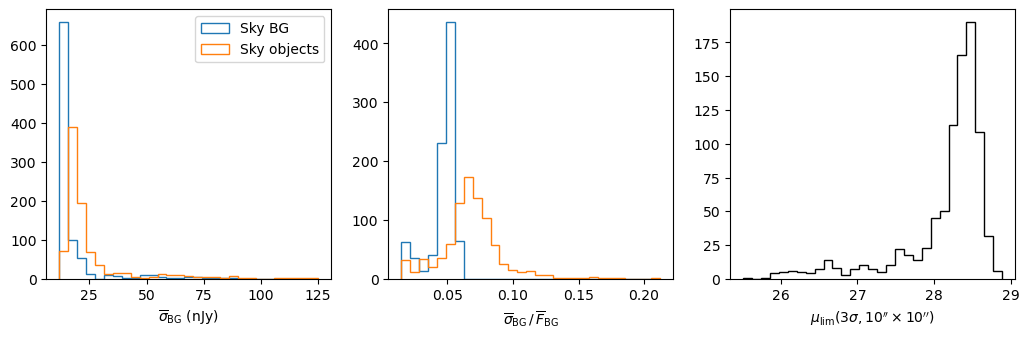

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12.5, 3.5))
# Standard deviation
N = 30  # Number of histogram bins
ax[0].hist(sigSkyBgs, np.linspace(np.nanmin(sigSkyBgs), np.nanmax(sigSkyObjs), N), histtype="step", label="Sky BG")
ax[0].hist(sigSkyObjs, np.linspace(np.nanmin(sigSkyBgs), np.nanmax(sigSkyObjs), N), histtype="step", label="Sky objects")
ax[0].legend()
ax[0].set_xlabel(r"$\overline{\sigma}_{\rm BG}$ (nJy)")

# Standard deviation / mean background flux
ax[1].hist(noiseFracBgs, np.linspace(np.nanmin(noiseFracBgs), np.nanmax(noiseFracObjs), N), histtype="step", label="Sky BG")
ax[1].hist(noiseFracObjs, np.linspace(np.nanmin(noiseFracBgs), np.nanmax(noiseFracObjs), N), histtype="step", label="Sky objects")
ax[1].set_xlabel(r"$\overline{\sigma}_{\rm BG}\, /\, \overline{F}_{\rm BG}$")

# Limiting surface brightness
ax[2].hist(muLims, np.linspace(np.nanmin(muLims), np.nanmax(muLims), N), histtype="step", color="k")
ax[2].set_xlabel(r"$\mu_{{\rm lim}} (3\sigma, 10^{\prime\prime}\times10^{\prime\prime})$")

Create violin plots showing distributions of standard deviations in sky-subtracted backgrounds for each visit (left panel), and distributions of ratios between those standard deviations and the mean sky brightness (right panel).  Show the values derived from the image backgrounds as blue violins, and the values derived from the sky objects as orange violins.  To meet the requirements, the latter must be < 0.01 (red dotted line in right panel).  Red x's show same metrics  evaluated from sky objects.  To avoid clutter, display only 10 visits.

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2024_50/conda/envs/lsst-scipipe-9.0.0-ext/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Text(0, 0.5, '$\\mu_{{\\rm lim}} (3\\sigma, 10^{\\prime\\prime}\\times10^{\\prime\\prime})$')

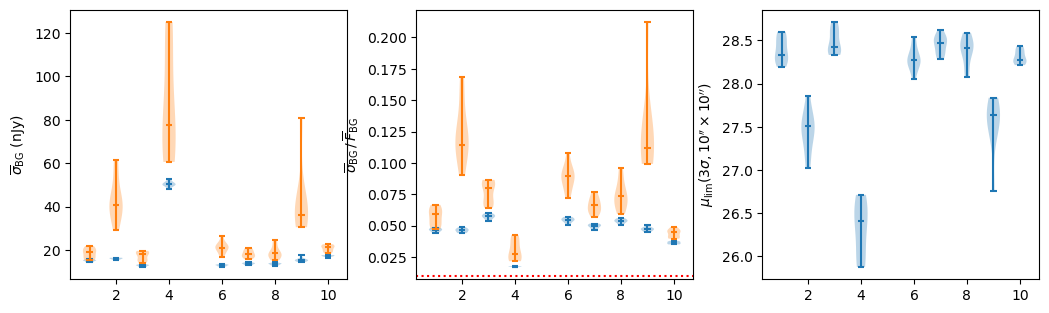

In [13]:
# Pick 10 visits of the full sample at random, or all if len < 10
if len(visits) < 10:
    idx = np.arange(len(visits))
else:
    idx = rng.choice(np.arange(len(visits)), size=10, replace=False)

fig, ax = plt.subplots(1, 3, figsize=(12.5, 3.5))
# Standard deviation
# From background flux distributions
ax[0].violinplot([noiseDict[visits[i]]["sigSkyBg"] for i in idx],
                 showmedians=True)
# From sky objects
ax[0].violinplot([noiseDict[visits[i]]["sigSkyObj"] for i in idx],
                showmedians=True)
ax[0].set_ylabel(r"$\overline{\sigma}_{\rm BG}$ (nJy)")

# Standard deviation / mean background flux
# From background flux distributions
ax[1].violinplot([noiseDict[visits[i]]["noiseFracBg"] for i in idx],
                showmedians=True)
# From sky objects
ax[1].violinplot([noiseDict[visits[i]]["noiseFracObj"] for i in idx],
                showmedians=True)
ax[1].axhline(0.01, c="r", linestyle=":")
ax[1].set_ylabel(r"$\overline{\sigma}_{\rm BG}\, /\, \overline{F}_{\rm BG}$")
plt.subplots_adjust(wspace=0.25)

# Limiting surface brightness
ax[2].violinplot([noiseDict[visits[i]]["muLim"] for i in idx],
                 showmedians=True)
ax[2].set_ylabel(r"$\mu_{{\rm lim}} (3\sigma, 10^{\prime\prime}\times10^{\prime\prime})$")

#### Results

We have demonstrated that the sky estimation precision metric `SBPerc` can be tested using `calexp` images, their associated `skyCorr` models, and the sky objects values stored in the `sourceTable_visit` tables produced by the Rubin Science Pipelines.  The result of this test is "**Fail**"; in no visits do we find that `SBPerc < 1`.

Alternatively, we tested this metric on images taken with the Burrell Schmidt Telescope (KPNO), an LSB-optimized telescope, which were processed using an LSB-optimized pipeline and heavily masked, and found values of $\sim2$% even there.  We have defined "precision" as effectively a signal-to-noise ratio.  As sky counts are expected to follow Poisson statistics, like every other source, S/N reduces with brighter skies, hence this metric is sensitive to the initial sky brightness.  Failure to satisfy the `SBPerc < 1` criteria thus is not that concerning.

Because we do not expect to be able to reach the `SBPerc < 1` threshold consistently, we propose using a metric more frequently employed by the low surface brightness community, based only on the background noise: the limiting surface brightness.  This is a value the LSB community will be interested in tracking throughout the survey, as more data is acquired and as the pipeline is refined, particularly on image coadds.

Reference: Roman, J., Trujillo, I., & Montes, M., 2020, A & A, 644, 42